# BE/Bi 103, Fall 2015: Homework 5
## Due 1pm, Monday, November 9

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5.ipynb).*

In [93]:
import collections
import warnings

# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numdifftools as ndt

# Use Numba for speed
import numba

# Plotting modules
import matplotlib.pyplot as plt
import corner

# BE/Bi 103 utilities
import bebi103

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 5.1: Dancing (80 pts)

*This problem was inspired by Geoff Cumming.*

In this problem, we will investigate how **replicable** certain statistical conclusions, both the frequentist and Bayesian contexts, are.  What I mean by replicability is best understood be working through the problem.

For this tutorial we will use the zebrafish embryo sleep data we have been using before.  We will investigate one of the metrics we considered in [Tutorial 2b](../tutotials/t2b_defining_and_estimating_parameters.html).  We will study the mean rest bout length on the third night, comparing wild type to the homozygous mutant.  You could work through Tutorial 2b again to process the bout lengths and get the data, but I provide them for you [here](../data/mean_rest_bouts.csv).

As a reminder, two of the mutant fish had no detectable rest bouts on the one-minute sampling interval.  They obviously did have rest bouts, but they were smaller than one minute.  We therefore have a decision: we can either choose the mean rest bout length to be zero for these fish, or we can jettison them from our samples because we know we could not properly sample them.  For the purposes of this problem, we will include these fish and take their mean bout length to be zero.

Let's remind ourselves of what the data look like.

In [94]:
# Load data
df = pd.read_csv('../data/gandhi_et_al/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

Let's look at these data with a jitter plot.

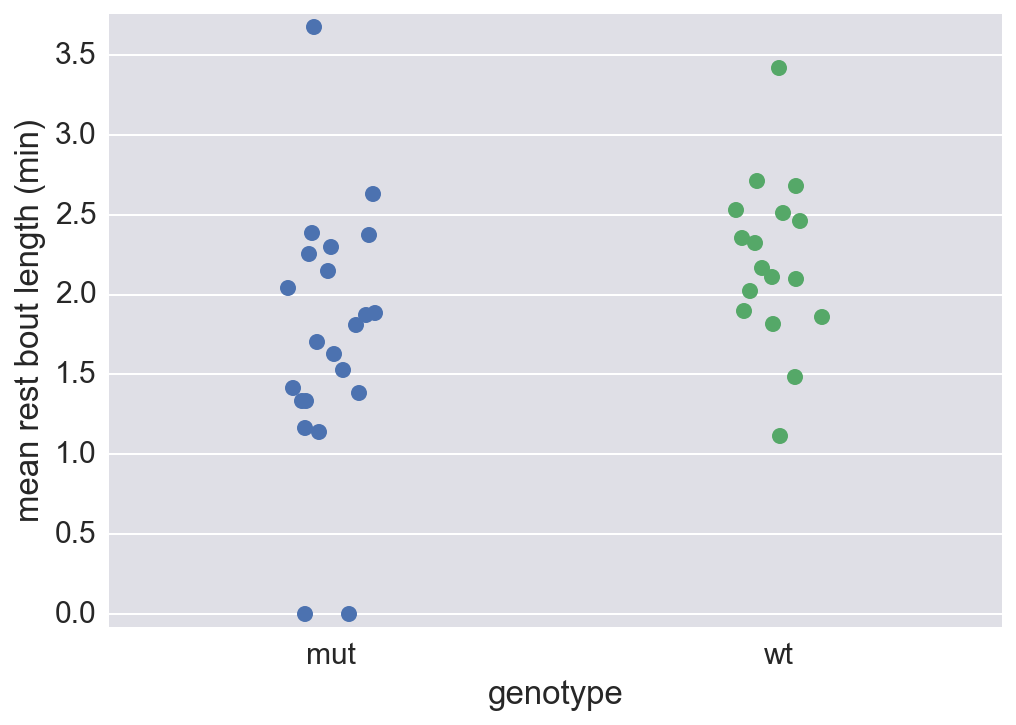

In [95]:
# Make strip plot
sns.stripplot(x='genotype', y='mean_rest_bout_length', data=df, jitter=True)

# Label axes 
plt.ylabel('mean rest bout length (min)')
plt.margins(y=0.02)

By eye, is looks like the wild type has a longer mean rest bout length than the mutant.  We will investigate this claim using parametric frequentist and Bayesian methods.  We will assume these data are Gaussian distributed each with their own mean $\mu$ and variance $\sigma^2$.

**a)** Estimate the values of $\mu$ and $\sigma^2$ for the wild type and mutant populations using an unbiased frequentist estimator.  We will denote these as $\mu_w$, $\sigma^2_w$, $\mu_m$, and $\sigma^2_m$.  Also compute Cohen's d to measure the effect size between these two.

**b)** Compute a frequentist estimate for the difference of the means, $\delta \equiv \mu_w - \mu_m$ and a reasonable 95% confidence interval.

**c)** Compute a reasonable Bayesian estimate for $\delta$ and give a credible region.

**d)** Consider the hypothesis $H_0$, which says that the mutant and wild type populations are drawn from the same Gaussian distribution.  Perform a frequentist hypothesis test to compute the p-value corresponding to this hypothesis.

**e)** Consider hypothesis $H_1$ that says that they are drawn from different Gaussian distributions with their own mean $\mu$ and variance $\sigma^2$, as we assumed at the beginning.  Compute an approximate Bayesian odds ratio,

\begin{align}
O_{01} = \frac{P(H_0\mid D, I)}{P(H_1\mid D, I)}.
\end{align}

*Hint*: Some of the results from lecture 2 might make this calculation easier.  In fact, you can use some fairly simple analytical results to quickly compute the odds ratio.  Or you can hit it with an MCMC hammer if you feel like giving your computer a workout.

**f)** We will now "repeat" the experiment.  Generate a set of mean sleep bout lengths for 17 wild type fish by drawing the bout lengths out of a Gaussian distribution with mean $\mu_w$ and variance $\sigma_w^2$, using the values you estimated in part (a).  Do the same for 22 mutant fish using $\mu_m$ and $\sigma_m$ as estimated in part (a).  For this new group of fish, repeat parts (b) through (e).  That is, compute the frequentist confidence interval for $\delta$, a Bayesian credible region for $\delta$, a frequentist p-value for hypothesis $H_0$, and a Bayesian odds ratio $O_{01}$.  

Do this procedure, where you generate new data from your mean and variances in part (a) and compute these quantities, 100 times.  Make plots that show how the confidence intervals, credible regions, p-values, and odds ratios "dance" as you repeat the experiment.  What lessons do you take away from this?

### Problem 5.1: solution
We will also consider the case where we drop the fish where we could not detect rest bouts to show the results are general.  In general, it will be easiest to split our two samples into NumPy arrays first.

In [96]:
# Load data
df = pd.read_csv('../data/gandhi_et_al/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant
df = df[df['genotype'].isin(['wt', 'mut'])]

# For convenience, store each as a NumPy array, inserting zero for NaN
wt = df[df['genotype']=='wt']['mean_rest_bout_length'].values
mut = df[df['genotype']=='mut']['mean_rest_bout_length'].fillna(0).values
mut_no_zeros = df[df['genotype']=='mut']['mean_rest_bout_length'].dropna().values

**a)** We use an unbiased frequentist estimate for $\mu$ and $\sigma$, as derived in [Tutorial 6a](../tutorials/t6a_frequentist_parameter_estimation.html).  We'll also use the function we wrote to compute Cohen's d in [Tutorial 6b](../tutorials/t6b_frequentist_hypothesis_testing.html).

In [97]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

# Estimate parameters
mu_wt = wt.mean()
var_wt = wt.var(ddof=1)

mu_mut = mut.mean()
var_mut = mut.var(ddof=1)

# Compute Cohen's d
d = cohen_d(mut, wt)

# Print results
print("""
        µ       σ         σ2    
     -------------------------
WT    {0:.2f}    {1:.2f}     {2:.2f}
MUT   {3:.2f}    {4:.2f}     {5:.2f}

""".format(mu_wt, np.sqrt(var_wt), var_wt, mu_mut, np.sqrt(var_mut), var_mut))

print('Cohen\'s d: {0:.2f}'.format(d))


        µ       σ         σ2    
     -------------------------
WT    2.21    0.52     0.27
MUT   1.73    0.81     0.65


Cohen's d: 0.71


The Cohen's d value says that the wild type has a mean mean rest bout length about 0.7 standard deviations above that of the mutant.  This is perhaps the most useful comparison between the two.

**b)** We posit that the difference in the sample means is the unbiased estimator for the difference in means.  Let us check if that works.  We will denote the measurement of the mean rest bout length for fish $i$ by $x_i$.

\begin{align}
\left\langle\bar{x}_w - \bar{x}_m \right\rangle 
&= \left\langle\bar{x}_w\right\rangle - \left\langle \bar{x}_m \right\rangle
= \mu_w - \mu_m,
\end{align}

where we used the result derived in [Tutorial 6a](http://bebi103.caltech.edu/2015/tutorials/t6a_frequentist_parameter_estimation.html) in the last line.  So, our estimator in the difference of the means is:

In [98]:
print("""
difference in means = {0:.2f} min""".format(wt.mean() - mut.mean()))


difference in means = 0.48 min


To compute the confidence interval, we will do a parametric bootstrap estimate by drawing samples out of Gaussian distributions with the same mean and standard deviation as observed respectively in wild type and mutant.  We then subtract the two means to get $P(\mu_w-\mu_m)$.  Rememnber: this is a frequentist probability, not a Bayesian one.  Is is the probability of obtaining an estimate for the difference in means in a hypothetical repeated experiment.

We will use the `gaussian_draw()` function from Tutorial 6a.

In [99]:
def gaussian_draw(mu, sigma, stat_fun, n, n_trials=10000, args=()):
    """
    Make draws from Gaussian distribution with mean mu and 
    standard deviation sigma and compute and tabulate a
    statistic using `stat_fun`.  `stat_fun` must have the form
    stat_fun(x, *args), where `x` is a NumPy array of draws.
    """
    return np.array([
            stat_fun(np.random.normal(loc=mu, scale=sigma, size=n), *args) 
            for _ in range(n_trials)])

# "Repeat" experiments
samples_wt = gaussian_draw(mu_wt, np.sqrt(var_wt), np.mean, len(wt), 
                        n_trials=100000)
samples_mut = gaussian_draw(mu_mut, np.sqrt(var_mut), np.mean, len(wt), 
                        n_trials=100000)

# Compute differences in the mean
diff_samples = samples_wt - samples_mut

Now that we have our bootstrap estimates, we can plot the probability distribution and report a 95% confidence interval.


95% confidence interval for µw - µm = [0.03, 0.94] min



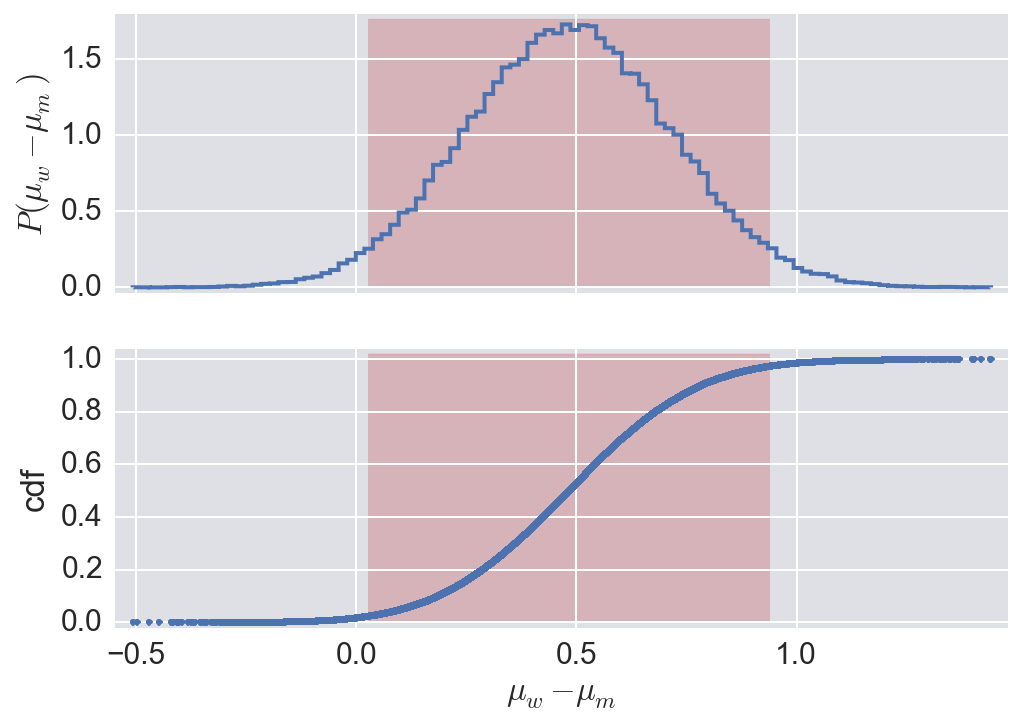

In [100]:
# Compute 95% confidence interval
conf_int = np.percentile(diff_samples, (2.5, 97.5))
print("""
95% confidence interval for µw - µm = [{0:.2f}, {1:.2f}] min
""".format(*tuple(conf_int)))

# Generate CDF
x = np.sort(diff_samples)
y = np.arange(len(diff_samples)) / len(diff_samples)

# Make plots
fig, ax = plt.subplots(2, 1, sharex=True)
_ = ax[0].hist(diff_samples, normed=True, bins=100, lw=2, histtype='step')
ax[0].set_ylabel(r'$P(\mu_w - \mu_m)$')
ax[0].margins(0.02)

ax[1].plot(x, y, '.')
ax[1].set_ylabel('cdf')
ax[1].set_xlabel(r'$\mu_w - \mu_m$')
ax[1].margins(0.02)

# Shade confidence interval
for i in [0,1]:
    ax[i].fill_between(x, 0.0, ax[i].get_ylim()[1], 
                       where=((0.025 < y) & (y < 0.975)), 
                       color=sns.color_palette()[2], alpha=0.3, zorder=0) 

We could also compute the confidence interval using a nonparametric bootstrap.


95% confidence interval for µw - µm = [0.08, 0.90] min



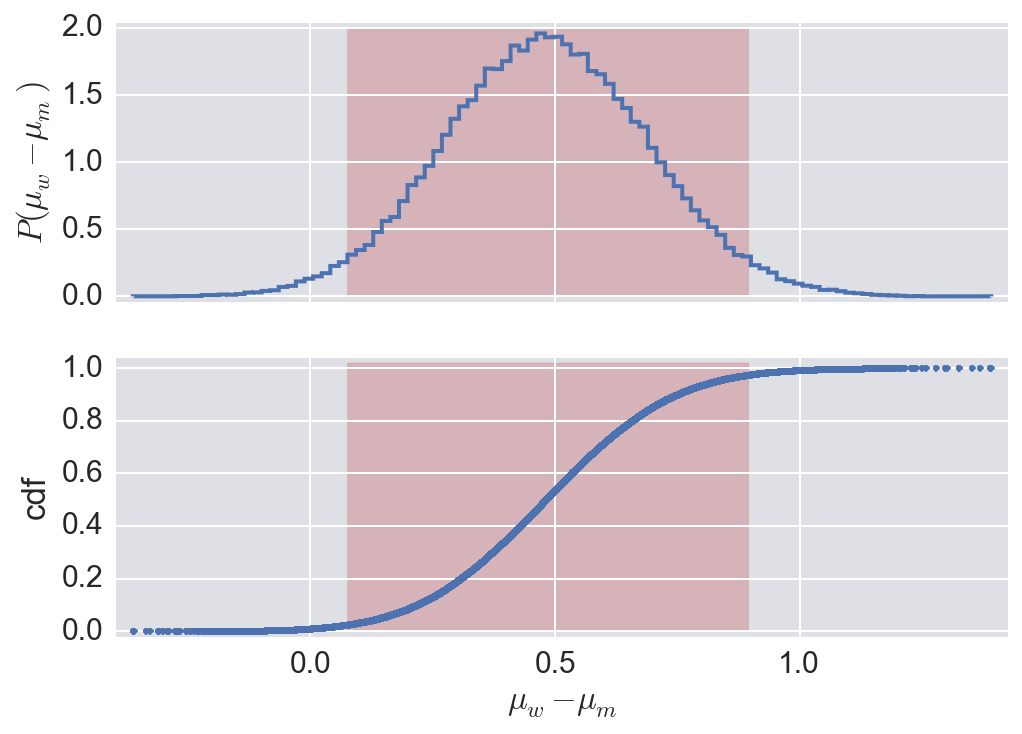

In [101]:
def bootstrap_repeated_measurements(x, stat_fun, args=(), n_trials=1000):
    """
    Get bootstrap samples of a statistic from repeated
    measurements `x`.  `stat_fun` must be of the form
    stat_fun(x, *args).
    """
    # Indices that we use for resampling
    inds_to_choose = np.arange(len(x), dtype=int)   
    
    # Samples to save
    samples = np.empty(n_trials)
    
    return np.array(
        [stat_fun(x[np.random.choice(inds_to_choose, len(x), replace=True)])
                   for _ in range(n_trials)])

# "Repeat" experiment
samples_wt = bootstrap_repeated_measurements(wt, np.mean, n_trials=100000)
samples_mut = bootstrap_repeated_measurements(mut, np.mean, n_trials=100000)

# Compute differences in the mean
diff_samples = samples_wt - samples_mut

# Compute 95% confidence interval
conf_int = np.percentile(diff_samples, (2.5, 97.5))
print("""
95% confidence interval for µw - µm = [{0:.2f}, {1:.2f}] min
""".format(*tuple(conf_int)))

# Generate CDF
x = np.sort(diff_samples)
y = np.arange(len(diff_samples)) / len(diff_samples)

# Make plots
fig, ax = plt.subplots(2, 1, sharex=True)
_ = ax[0].hist(diff_samples, normed=True, bins=100, lw=2, histtype='step')
ax[0].set_ylabel(r'$P(\mu_w - \mu_m)$')
ax[0].margins(0.02)

ax[1].plot(x, y, '.')
ax[1].set_ylabel('cdf')
ax[1].set_xlabel(r'$\mu_w - \mu_m$')
ax[1].margins(0.02)

# Shade confidence interval
for i in [0,1]:
    ax[i].fill_between(x, 0.0, ax[i].get_ylim()[1], 
                       where=((0.025 < y) & (y < 0.975)), 
                       color=sns.color_palette()[2], alpha=0.3, zorder=0) 

The bootstrap interval is a bit tighter because Gaussianity was not assumed.

**c)** Because we need speed later, we will not use MCMC to get our Bayesian estimate of the mean, but instead do some analytical work ahead of time and then use optimization.

We have two data sets, $D_w$ and $D_m$ which we assume to be drawn from independent Gaussian processes with differing means and differing variances.  Assuming a Jeffreys prior on the parameters, our posterior is

\begin{align}
P(\mu_w,\sigma_w,\mu_m,\sigma_m\mid D_w,D_m,I) &\propto\frac{1}{\sigma_w\sigma_m}
\left(\prod_{i\in D_w} \frac{\mathrm{e}^{-(x_i-\mu_w)^2/2\sigma_w^2}}{\sqrt{2\pi\sigma_w^2}}\right)
\left(\prod_{i\in D_m} \frac{\mathrm{e}^{-(x_i-\mu_m)^2/2\sigma_m^2}}{\sqrt{2\pi\sigma_m^2}}\right) \\[1em]
&\!\!\!\!\!\!\!\!\!\!\propto
\frac{1}{\sigma_w^{n_w+1}\sigma_m^{n_m+1}}\,\exp\left[
-\frac{1}{2\sigma_w^2}\sum_{i\in D_w}(x_i-\mu_w)^2
-\frac{1}{2\sigma_m^2}\sum_{i\in D_m}(x_i-\mu_m)^2
\right]
\end{align}

We saw in [lecture 2](http://bebi103.caltech.edu/2015/lecture_notes/l02_parameter_estimation.pdf) that

\begin{align}
\sum_{i\in D}(x_i-\mu)^2 = n(\bar{x} - \mu)^2 + nr^2,
\end{align}

where $\bar{x}$ is the sample mean and $r^2$ is the sample variance.  Thus, we can write our posterior as

\begin{align}
P(\mu_w,\sigma_w,\mu_m,\sigma_m\mid D_w,D_m,I) &\propto
\frac{\mathrm{e}^{-n_w r_w^2/2\sigma_w^2}\,\mathrm{e}^{-n_m r_m^2/2\sigma_m^2}}{\sigma_w^{n_w+1}\sigma_m^{n_m+1}}\\[1em]
&\;\;\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(\mu_w-\bar{x}_w\right)^2
-\frac{n_m}{2\sigma_m^2}\left(\mu_m-\bar{x}_m\right)^2
\right].
\end{align}

We now make a change of variables.  Let $\delta = \mu_w-\mu_m$ and $\gamma = \mu_w + \mu_m$.  Then, $\mu_w = (\gamma + \delta) / 2$ and $\mu_m = (\gamma - \delta) / 2$.  When we apply the change of variables formula, we only get a constant factor of $1/2$ multiplying the posterior, so we have

\begin{align}
P(\gamma, \delta, \sigma_w, \sigma_m\mid D_w, D_m, I) \propto
&\frac{\mathrm{e}^{-n_w r_w^2/2\sigma_w^2}\,\mathrm{e}^{-n_m r_m^2/2\sigma_m^2}}{\sigma_w^{n_w+1}\sigma_m^{n_m+1}}\\[1em]
&\;\;\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(\frac{\gamma + \delta}{2}-\bar{x}_w\right)^2
-\frac{n_m}{2\sigma_m^2}\left(\frac{\gamma - \delta}{2}-\bar{x}_m\right)^2
\right].
\end{align}

So, the log posterior is

\begin{align}
\ln P(\gamma, \delta, \sigma_w, \sigma_m\mid D_w, D_m, I) =&\;\text{constant} - (n_w+1) \ln \sigma_w - (n_m+1)\ln \sigma_m
- \frac{n_w r_w^2}{2\sigma_w^2} - \frac{n_m r_m^2}{2\sigma_m^2} \\[1em]
&\;\;- \frac{n_w}{2\sigma_w^2}\left(\frac{\gamma + \delta}{2}-\bar{x}_w\right)^2
- \frac{n_m}{2\sigma_m^2}\left(\frac{\gamma - \delta}{2}-\bar{x}_m\right)^2.
\end{align}

Clearly, regardless of the value of $\sigma_m$ and $\sigma_w$, the log posterior is maximal when $\delta = \bar{x}_w - \bar{x}_m$ and $\gamma = \bar{x}_w + \bar{x}_m$.  Given that this, the last two terms in the log posterior are zero at the MAP.  We can then solve for the MAP values of $\sigma_m$ and $\sigma_w$ analytically by differentiating and setting the derivative equal to zero.  For $\sigma_w$, for example,

\begin{align}
\frac{\partial \ln P}{\partial \sigma_w} = -\frac{n_w+1}{\sigma_w} 
+ \frac{n_w r_w^2}{\sigma_w^3}.
\end{align}

Setting this equal to zero and solving for $\sigma_w$ gives the result that

\begin{align}
\sigma_w^* = \sqrt{\frac{n_w}{n_w+1} r_w^2}.
\end{align}

Note that this is different from the frequentist unbiased estimator.  We are choosing the value of $\sigma_w$ at the MAP, not $\sqrt{\langle \sigma_w^2\rangle}$, which is what the frequentist unbiased estimator is after.

Now that we have the MAP, we just have to find the Hessian of the log posterior, take the negative of its inverse, and we have the covariance matrix.  This involves significant algebraic grunge I do not presently wish to sully my hands doing.  I will just use numerical differentiation to do it, but for reference the analytical result is that
\begin{align}
\delta = \bar{x}_w - \bar{x}_m \pm \sqrt{\frac{r_m^2}{1+n_m} + \frac{r_w^2}{1+n_w}}.
\end{align}

(Actually I did sully my hands doing it; I just didn't want to $\TeX$ it up.)

We will derive a result like this later in a clearer fashion in lecture when we do error propagation.  For now, I will take this as given.  We will take our credible region to be ± 2 standard deviations, which contains 95% of the probability under the Gaussian approximation of the posterior.

All of this analytical work was not really necessary, as we can just lean on efficient numerical methods instead.  I will use those going forward.  Since we need to specify bounds on the parameters in part (e) during model selection, I include more detail that necessary in the prior here.  The details will be explained in part (e).

In [102]:
def log_likelihood_diff(p, x, y):
    """
    Log likelihood for two Gaussian processes.  
    Parameters are:
        gamma = mu_y + mu_x
        delta = mu_y - mu_x
        sigma_x
        sigma_y
    """
    # Unpack parameters
    gamma, delta, sigma_x, sigma_y = p
    
    # Compute mu's from gamma and delta
    mu_x = (gamma - delta) / 2
    mu_y = (gamma + delta) / 2
    
    return -len(y) * np.log(sigma_y) - len(x) * np.log(sigma_x) \
           - len(y) / 2 / sigma_y**2 * ((mu_y - y.mean())**2 + y.var()) \
           - len(x) / 2 / sigma_x**2 * ((mu_x - x.mean())**2 + x.var())
        
        
def log_prior_diff(p, mu_min=0, mu_max=600, sigma_min=1e-2, sigma_max=200):
    """
    Log prior for two Gaussian processes.  
    Parameters are:
        gamma = mu_y + mu_x
        delta = mu_y - mu_x
        sigma_x
        sigma_y
    """
    #  Unpack
    gamma, delta, sigma_x, sigma_y = p
    
    # Compute mu's from gamma and delta
    mu_x = (gamma - delta) / 2
    mu_y = (gamma + delta) / 2
    
    # Check ranges
    if not ((mu_min < mu_x < mu_max) and (mu_min < mu_y < mu_max)):
        return -np.inf
    
    if not ((sigma_min < sigma_x < sigma_max) 
            and (sigma_min < sigma_y < sigma_max)):
        return -np.inf
    
    # Compute log prior
    return -np.log(2) - 2 * np.log(mu_max - mu_min) \
            - 2 * np.log(np.log(sigma_max / sigma_min)) \
            - np.log(sigma_x) - np.log(sigma_y)


def log_posterior_diff(p, x, y, mu_min=0, mu_max=600, 
                       sigma_min=1e-2, sigma_max=200):
    """
    Log posterior for two Gaussian processes.  Parameters are:
        gamma = mu_y + mu_x
        delta = mu_y - mu_x
        sigma_x
        sigma_y
    """
    lp = log_prior_diff(p, mu_min, mu_max, sigma_min, sigma_max)
    if lp == -np.inf:
        return -np.inf
    return lp + log_likelihood_diff(p, x, y)

    
def neg_log_posterior_diff(p, x, y, mu_min, mu_max, sigma_min, sigma_max):
    return -log_posterior_diff(p, x, y, mu_min, mu_max, sigma_min, sigma_max)

    
def two_gaussian_process_map(x, y, p0=None, mu_min=0, mu_max=600,
                             sigma_min=1e-2, sigma_max=200):
    """
    Given two samples from independent data sets, $x$ and $y$, compute
    MAP
    """
    # Get initial guess close to expected MAP
    if p0 is None:
        mu_x = x.mean()
        mu_y = y.mean()
        gamma_0 = (mu_y + mu_x) / 2
        delta_0 = (mu_y - mu_x) / 2
        p0 = np.array([gamma_0, delta_0, x.std(), y.std()])
        
    # Specify arguments to pass to log posterior
    args = (x, y, mu_min, mu_max, sigma_min, sigma_max)
    
    # Find the MAP
    res = scipy.optimize.minimize(neg_log_posterior_diff, p0, args=args, 
                                  method='powell')
    return res.x


def popt_and_cov(x, y, p0=None, mu_min=0, mu_max=600, 
                 sigma_min=1e-2, sigma_max=200):
    """
    Compute MAP for parameter delta = mu_y - mu_x and 
    its error bar (times error_bar_factor).
    """
    # Get MAP
    popt = two_gaussian_process_map(x, y, p0, mu_min, mu_max, 
                                    sigma_min, sigma_max)
    
    # Compute covariance matrix
    hes_fun = ndt.Hessian(log_posterior_diff)
    hes = hes_fun(popt, x, y, mu_min, mu_max, sigma_min, sigma_max)
    cov = -np.linalg.inv(hes)

    # Return parameters and covariance matrix
    return popt, cov

We'll now calculated our estimate with a 95% credible region.

In [103]:
popt, cov = popt_and_cov(mut, wt)

print("""
     δ MAP = {0:.2f} min
δ conf int = [{1:.2f}, {2:.2f}] min
""".format(popt[1], popt[1] - 2 * np.sqrt(cov[1,1]),
           popt[1] + 2 * np.sqrt(cov[1,1])))


     δ MAP = 0.48 min
δ conf int = [0.08, 0.89] min



The Bayesian credible region is a little tighter.  This is due to approximating the posterior as a Gaussian, where the marginalized posterior is actually a Student-t distribution, which is a bit broader than a Gaussian.

**d)** To perform the frequentist hypothesis test, we perform permutation, just like in [Tutorial 6b](http://bebi103.caltech.edu/tutorials/t6b_frequentist_hypothesis_testing.html), and look at the difference in means.  We borrow functions from that tutorial and let 'er rip.

In [104]:
def permute_sample(x, y, stat_fun, args=(), n_trials=1000):
    """
    Considered two arrays `x` and `y` as one and then selects
    random samples out of the combined array the same size as
    the original `x` and `y`.  The computes test statistic for each
    sample.
    """
    # Array to store samples
    samples = np.empty(n_trials)

    # Put the two data sets together
    vals = np.concatenate((x, y))
    
    for i in range(n_trials):
        # Permute and compute difference in means
        vals = np.random.permutation(vals)
        samples[i] = stat_fun(vals[:len(x)], vals[len(x):], *args)
        
    return samples

def p_value_from_samples(samples, actual, greater_or_less='greater'):
    """
    Compute probability that actual values if either greater than
    or less than samples value.
    """
    
    # Compute p-value
    if greater_or_less == 'greater':
        return np.sum(samples >= actual) / len(samples)
    else:
        return np.sum(samples <= actual) / len(samples)
    
# Function for difference in means
def mean_diff(x, y, return_abs=False):
    diff = y.mean() - x.mean()
    if return_abs:
        return np.abs(diff)
    return diff

# Do the sampling and compute the p-value
samples = permute_sample(mut, wt, mean_diff, n_trials=100000)
p = p_value_from_samples(samples, mean_diff(mut, wt))

# Print result
print("""p-value = {0:.6f}""".format(p))

p-value = 0.017980


So, we get a p-value of 0.02, below the "magic" value of 0.05, so we might say that the difference in means in the two samples is statistically significant.

**e)** To compute the Bayesian odds ratio, we will use the approximate expression derived in lecture.

\begin{align}
O_{01} \approx &\left(\frac{P(H_0\mid I)}{P(H_1\mid I)}\right)
\left(\frac{P(D\mid \mu^*, \sigma^*, H_0, I)}{P(D_1, D_2\mid \mu_w^*, \sigma_w^*, \mu_m^*, \sigma_m^*, H_1, I)}\right) \\[1em]
&\;\;\;\;\times
\left(\frac{P(\mu^*, \sigma^* \mid H_0, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_0^2}}}
{P(\mu_w^*, \sigma_w^*, \mu_m^*, \sigma_m^*\mid H_2, I)\,(2\pi)^2 \sqrt{\det\boldsymbol{\sigma}_1^2}}\right),
\end{align}

I will take $P(H_0\mid I)/P(H_1\mid I) \approx 1$, assuming that we do not favor either model a priori.  To do the calculation, we need to compute the MAP and covariance for $H_0$, where the samples come from the same distribution.  To compute the other portions, we first consider the likelihood, prior, and posterior for Gaussian distributed data.  We'll start with the properly normalized Jeffreys prior.

\begin{align}
P(\mu,\sigma\mid I) = \frac{1}{\mu_\mathrm{max} - \mu_\mathrm{min}} \,
\frac{1}{\sigma\ln\left(\sigma_\mathrm{max}/\sigma_\mathrm{min}\right)}.
\end{align}

Thus, we have a log prior of

\begin{align}
\ln P(\mu,\sigma\mid I) = -\ln\left(\mu_\mathrm{max} - \mu_\mathrm{min}\right)
- \ln\left(\ln\left(\sigma_\mathrm{max}/\sigma_\mathrm{min}\right)\right)
- \ln \sigma.
\end{align}

Here, we have specified the bounds on $\mu$ and $\sigma$.  What might be reasonable in the present context?  Well, obviously, $0 \le \mu \le 600$ minutes, since the length of a sleep bout must be nonnegative and there are 600 total minutes in the third night.  These are hard physical limits, but we can constrain $\mu$ further.  I think if I saw a fish sitting still for 10 hours, I would be pretty shocked if it weren't floating (i.e., dead).  So, perhaps a more reasonable bound on $\mu$ is one hour.  That still seems really long, but not outside the realm of reason.  How about $\sigma$?  Again, the standard deviation cannot be bigger than the actual night, so 600 is a hard upper bound.  Again, 10 hours of no movement would imply death, so we will choose $\sigma_\mathrm{max} = 60$ min.  For the lower bound, we might pick one second, since that is close to the sampling rate of the experiment.  So, $\sigma_\mathrm{min} = 1/60$.

Now, let's look at the likelihood.

\begin{align}
P(D\mid \mu, \sigma, I) = \left(\frac{1}{2\pi\sigma^2}\right)^{n/2}\,
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D} (x_i - \mu)^2\right],
\end{align}

giving a log likelihood of

\begin{align}
\ln P(D\mid \mu, \sigma, I) = -\frac{n}{2}\,\ln(2\pi) - n\ln\sigma - \frac{1}{2\sigma^2}\sum_{i\in D} (x_i - \mu)^2.
\end{align}

We saw in [lecture 2](http://bebi103.caltech.edu/2015/lecture_notes/l02_parameter_estimation.pdf) that

\begin{align}
\sum_{i\in D}(x_i-\mu)^2 = n(\bar{x} - \mu)^2 + nr^2,
\end{align}

where $\bar{x}$ is the sample mean and $r^2$ is the sample variance.  So, we can write the log likelihood as

\begin{align}
\ln P(D\mid \mu, \sigma, I) = -\frac{n}{2}\,\ln(2\pi) - n\ln\sigma - \frac{n(\bar{x} - \mu)^2 + nr^2}{2\sigma^2}
\end{align}

Thus, the log posterior is

\begin{align}
\ln P(\mu, \sigma\mid D, I) = \text{constant} - (n+1)\ln\sigma - \frac{n(\bar{x} - \mu)^2 + nr^2}{2\sigma^2},
\end{align}

a familiar sight.  We can solve analytically for the MAP.  First, we see immediately that no matter what value $\sigma$ takes on, the log posterior is maximized when $\mu^* = \bar{x}$, which we already knew from lecture.  Now, differentiating with respect to $\sigma$, we get

\begin{align}
\frac{\partial\ln P(\mu, \sigma\mid D, I)}{\partial \sigma} = 
 -\frac{n+1}{\sigma} 
+ \frac{n r^2}{\sigma^3},
\end{align}

where we have used the fact that $\mu^* = \bar{x}$ at the MAP.  Setting this equal to zero and solving for $\sigma$ gives the result that

\begin{align}
\sigma^* = \sqrt{\frac{n}{n+1} r^2}.
\end{align}

Now that we have our MAP, we can compute the covariance matrix, first finding the Hessian at the MAP.  To do so, we compute the second derivatives and evaluate them at the MAP, with $\mu = \bar{x}$ and $\sigma^2 = nr^2/(n+1)$.  It is conveniently diagonal (a feature of Gaussians).

\begin{align}
\mathsf{H} = -\begin{pmatrix}
\frac{n+1}{nr^2} & 0 \\
0 & \frac{(n+1)^2(n-3)}{n^3 r^2}
\end{pmatrix}.
\end{align}

This matrix is easily inverted, giving

\begin{align}
\boldsymbol{\sigma}^2 = \begin{pmatrix}
\frac{nr^2}{n+1} & 0 \\
0 & \frac{n^3 r^2}{(n+1)^2(n-3)}
\end{pmatrix}.
\end{align}

The determinant is then

\begin{align}
\det \boldsymbol{\sigma}^2 = \frac{n^4r^4}{(n+1)^3(n-3)}.
\end{align}

Now, if we have two separate independent processes as we do with $H_1$, the likelihood, prior, and posterior probabilities of each process multiply, so their logarithms add.  The MAP is found by finding the MAP of each independent Gaussian, and the determinant of the covariance matrix is just the product of the determinant of the respective single-process covariances.

So, we just need to code up log likelihoods, log priors, and covariance matrices for a single Gaussian and then we add them up to get two separate measurements.

In [105]:
def log_prior(p, mu_min, mu_max, sigma_min, sigma_max):
    """
    Log prior for a Gaussian likelihood/Jeffreys prior.
    """
    mu, sigma = p
    
    if not ((mu_min < mu < mu_max) and (sigma_min < sigma < sigma_max)):
        return -np.inf
    
    return -np.log(mu_max - mu_min) - np.log(np.log(sigma_max / sigma_min)) \
            - np.log(sigma)

    
def log_likelihood(p, x):
    """
    Gaussian log likelihood.
    """
    mu, sigma = p
    
    return len(x) / 2 * np.log(2*np.pi) - len(x) * np.log(sigma) \
                - len(x) * ((x.mean() - mu)**2 + x.var()) / 2 / sigma

    
def gauss_map(x):
    """
    Return MAP as np.array([mu, sigma])
    """
    return np.array([x.mean(), x.var() * len(x) / (len(x) + 1)])


def gauss_det_cov(x):
    """
    Returns determinant of covariance matrix.
    """
    n = len(x)
    return n**4 * x.var()**2 / (n + 1)**3 / (n - 3)

Now that we have these, we can compute the odds ratio.  We'll do it piece by piece.

In [106]:
def log_odds_ratio(x, y, mu_min, mu_max, sigma_min, sigma_max, 
                   log_prior_ratio=0):
    """
    Compute odds ratio for single process versus two
    processes with Gaussian likelihoods.
    """
    # Specify bounds on parameters
    bounds = (mu_min, mu_max, sigma_min, sigma_max)

    # Put data into one array for hypothesis zero
    z = np.concatenate((x, y))

    # Compute MAP for H0
    popt_0 = gauss_map(z)

    # Compute MAP for WT
    popt_x = gauss_map(x)

    # Compute MAP for mutant
    popt_y = gauss_map(y)

    # Log goodness of fit ratio
    log_goodfit = log_likelihood(popt_0, z) - log_likelihood(popt_x, x) \
                    - log_likelihood(popt_y, y)

    # Log of Occam factor
    log_occam_0 = log_prior(popt_0, *bounds) + np.log(2*np.pi) \
                        + np.log(gauss_det_cov(z)) / 2

    log_occam_1 = log_prior(popt_x, *bounds) + np.log(gauss_det_cov(x)) / 2 \
                  + log_prior(popt_y, *bounds) + np.log(gauss_det_cov(y)) / 2 \
                  + 2 * np.log(2*np.pi)

    log_occam = log_occam_0 - log_occam_1

    # Compute log odds ratio
    log_odds = log_prior_ratio + log_goodfit + log_occam
    
    # Return results
    return log_goodfit, log_occam, log_odds

Let's see what we get for the log odds ratio!

In [111]:
print("""
Goodness of fit ratio: {0:.5f}
          Occam ratio: {1:.5f}
           Odds ratio: {2:.5f}
""".format(*tuple(np.exp(log_odds_ratio(wt, mut, 0, 60, 1/60, 60)))))


Goodness of fit ratio: 0.00021
          Occam ratio: 71.30804
           Odds ratio: 0.01484



We see that $H_1$ describes the data much better, but it takes a hit with the Occam factor.  Still, we see about 100 to one odds that the mutant and wild type are two separate processes.  These odds ratios are not as overwhelming as ones we've seen previously, but nonetheless argue in favor of model $H_1$.

**f)** We just repeat what we did before over and over again with fresh data.  The only new step is to write a function that will generate new data.  To do that, we simply pull samples out of a Gaussian distribution (making sure not to pull any negative values, as those are unphysical).

In [112]:
def new_data(mu, var, n):
    """
    Generate new data
    """
    return np.maximum(np.random.normal(mu, np.sqrt(var), n), 0)

Now, we can proceed with the calculations we did before on each data set.  We will also compute the Welch's p-value for each new experiment as well, just in case we are concerned that our custom p-value will somehow yield different results than one of the classical tests.  As a reminder, the test statistic for the Welch's t-test is

\begin{align}
T = \frac{\bar{x}_w - \bar{x}_m}{\sqrt{r_w^2/n_w + r_m^2/n_m}},
\end{align}

where $r_w^2$ and $r_m^2$ are sample variances.  This is implemented as `st.ttest_ind()` using the kwarg `equal_var=False`.

In [128]:
# Number of new data sets to consider
n_new_data = 100

# Number of trials to use in frequenstist calcs
n_trials = 50000

# Set up arrays for storing results
conf_int = np.empty((2,n_new_data))
cred_reg = np.empty((2, n_new_data))
odds = np.empty(n_new_data)
p_values = np.empty(n_new_data)
welch_p_values = np.empty(n_new_data)

# Do calcs!
for i in range(n_new_data):
    # Generate new data
    new_wt = new_data(mu_wt, var_wt, len(wt))
    new_mut = new_data(mu_mut, var_mut, len(mut))
    
    # Compute the observed mu and var
    new_mu_wt = new_wt.mean()
    new_var_wt = new_wt.var(ddof=1)
    new_mu_mut = new_mut.mean()
    new_var_mut = new_mut.var(ddof=1)
    
    # "Repeat" experiments
    samples_wt = gaussian_draw(new_mu_wt, np.sqrt(new_var_wt), np.mean, 
                               len(new_wt), n_trials=n_trials)
    samples_mut = gaussian_draw(new_mu_mut, np.sqrt(new_var_mut), np.mean, 
                                len(new_wt), n_trials=n_trials)

    # Compute differences in the mean
    diff_samples = samples_wt - samples_mut
    
    # Compute confidence interval
    conf_int[:,i] = np.percentile(diff_samples, (2.5, 97.5))
    
    # Compute Bayesian credible region
    popt, cov = popt_and_cov(new_mut, new_wt)
    cred_reg[:,i] = np.array([popt[1] + st.norm.ppf(0.025) * np.sqrt(cov[1,1]),
                              popt[1] + st.norm.ppf(0.975) * np.sqrt(cov[1,1])])

    # Compute p-value
    samples = permute_sample(new_mut, new_wt, mean_diff, n_trials=n_trials)
    p_values[i] = p_value_from_samples(samples, mean_diff(new_mut, new_wt))
    
    # Compute Welch's p-value (divide by two to make it one-sided)
    welch_p_values[i] = st.ttest_ind(new_wt, new_mut, equal_var=False)[1] / 2
    
    # Compute odds ratio
    odds[i] = np.exp(log_odds_ratio(new_wt, new_mut, 0, 60, 1/60, 60)[-1])

Now that we've done all of these calculations, let's start making comparisons.  We'll start by plotting the frequentist and Bayesian confidence intervals/credible regions.  We'll plot the confidence interval as a bar, and then the bounds of the credible region as dots on the bars.

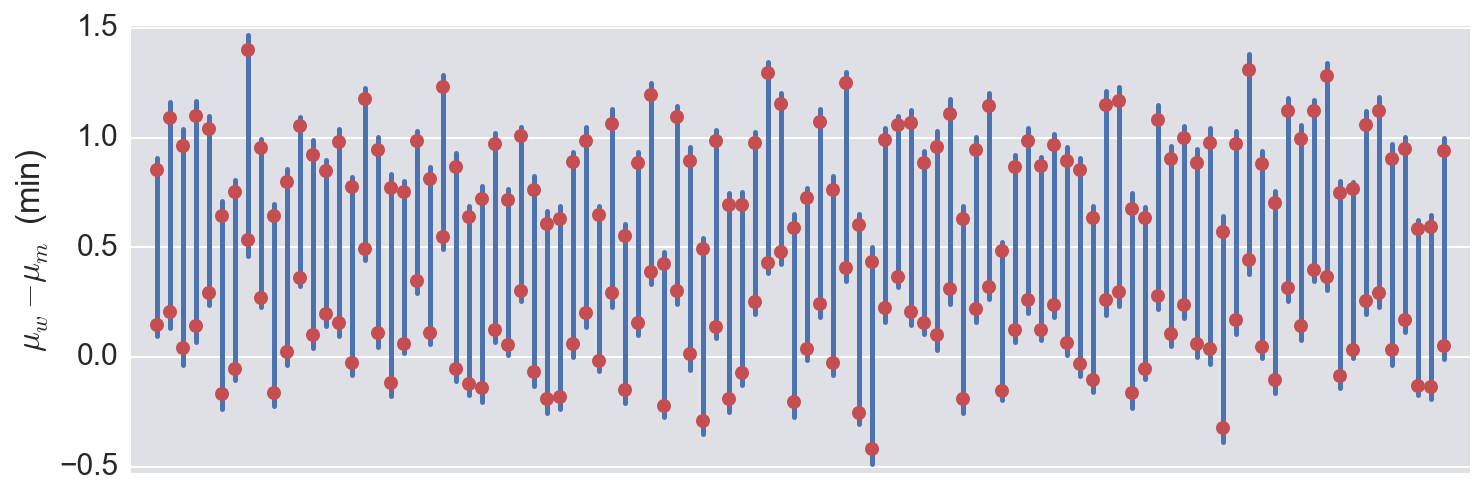

In [129]:
# Set up axis
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Make x-values for plotting to stagger
x = np.vstack(2*[np.arange(100).reshape((1, 100))])

# Plot the confidence intervals
ax.plot(x, conf_int, '-', color=sns.color_palette()[0])

# Plot the credible region bounds
ax.plot(x, cred_reg, 'o', color=sns.color_palette()[2]);

# Clean up
ax.set_ylabel(r'$\mu_w - \mu_m$ (min)')
ax.set_xticks([])
ax.margins(0.02)

The Bayesian credible region is always slightly shorter than the frequentist confidence interval.  This is because we approximated the Bayesian posterior as Gaussian, when in fact it is Student-t distributed.  The latter distribution is a bit wider, so we will slightly underestimate the width of the 95% credible region under the Gaussian approximation, which is what we are seeing in the above plot.  If we did not make the Gaussian approximation, the frequentist credible region and the Bayesian credible region exactly coincide.

More importantly, though, we see that the confidence interval can vary from experiment to experiment, but not that much.  Furthermore, just looking at this plot, we can see that the predicted value of $\delta$ is less than or equal to zero less than 1% of the time, since we don't see the center of any of the symmetric confidence intervals dipping below zero.  So, the confidence interval gives us a pretty good picture of what we're expect from subsequent experiments.

Now, let's look at the p-values.  First, we'll do a quick check to see how our custom p-value compares with that from the Welch's t-test.

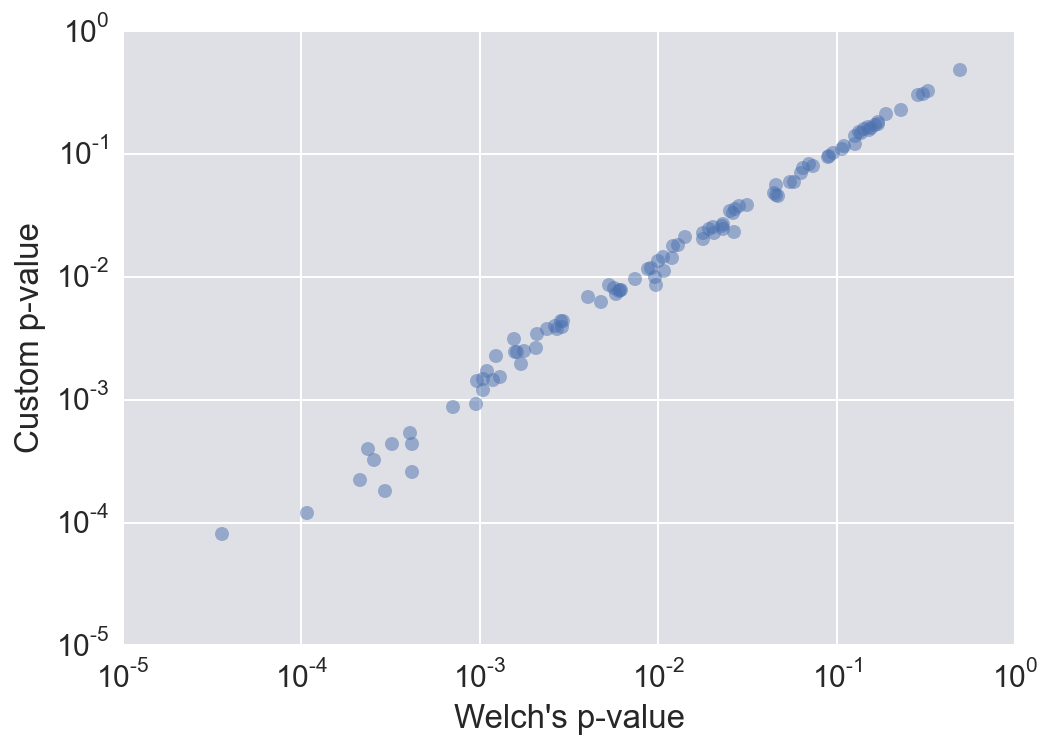

In [135]:
plt.loglog(welch_p_values, p_values, 'o', alpha=0.5)
plt.xlabel('Welch\'s p-value')
plt.ylabel('Custom p-value')

We get almost the same value of the p-value with our custom test statistic (just the difference in the means) vs. the Welch's one-sided t-test.

But what is really striking here is the scale!  Wow!  In 100 repeats, we get p-values ranging over four orders of magnitude!  That's three exclamations in a row!  Four, now.  Those exclamation points are there to highlight that the p-value is not a reproducible statistic at all.

Let's look at the Bayesian odds ratio.

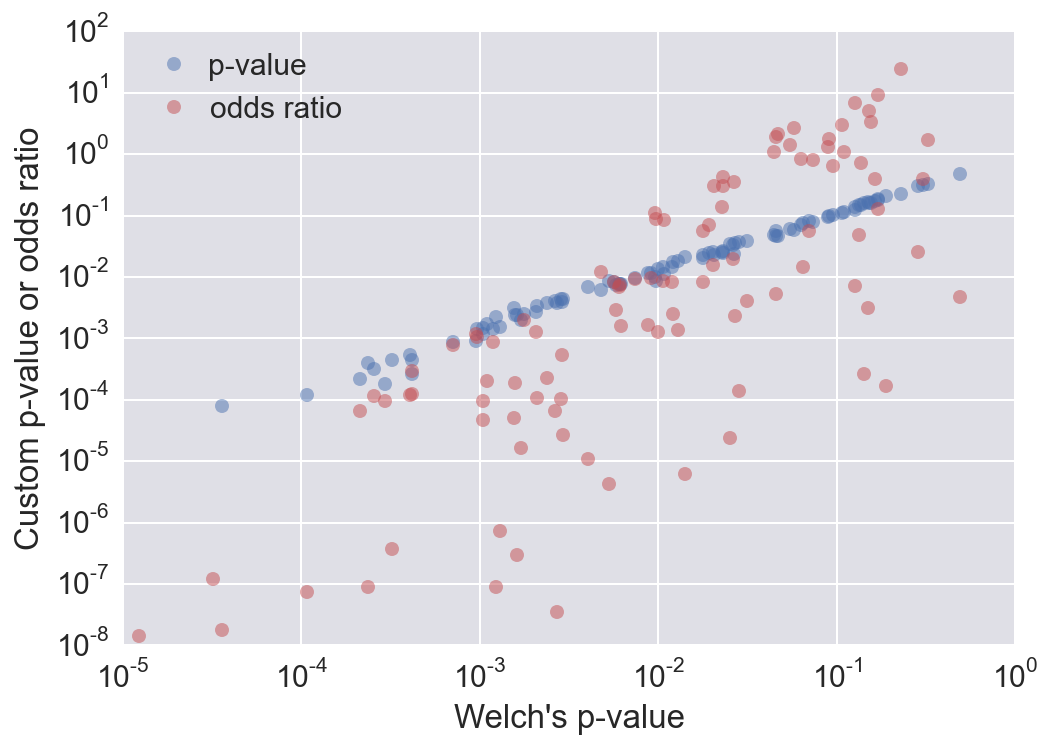

In [139]:
plt.loglog(welch_p_values, p_values, 'o', alpha=0.5, label='p-value')
plt.loglog(welch_p_values, odds, 'o', alpha=0.5, color=sns.color_palette()[2],
           label='odds ratio')
plt.xlabel('Welch\'s p-value')
plt.ylabel('Custom p-value or odds ratio')
plt.legend(loc='upper left');

The odds ratio only loosely correlates with the p-value.  This might not be surprising because it they are measuring two different things.  The p-value, as we have discussed many times, is the probability of observing a given value of a test statistic assuming the null hypothesis is true.  The odds ratio is the ratio of the probability that the null hypothesis is true given the data to the probability that an alternative hypothesis is true given the data.  Two different things.

The odds ratio varies by eight orders of magnitude.  For some sets of measurements, it is almost certain that the data come from two distributions.  For others, it is quite likely that they do not.  We can get more detail about the distribution of odds ratios by doing many more "repeats" of our experiments and plot a histogram.  We can do this because the odds ration calculation is fast.

In [165]:
n_new_data = 10000
odds = np.empty(n_new_data)

# Do calcs!
for i in range(n_new_data):
    # Generate new data
    new_wt = new_data(mu_wt, var_wt, len(wt))
    new_mut = new_data(mu_mut, var_mut, len(mut))

    # Compute odds ratio
    odds[i] = np.exp(log_odds_ratio(new_wt, new_mut, 0, 60, 1/60, 60)[-1])

We'll use KDE to make a plot of the probability distribution of odds ratios.

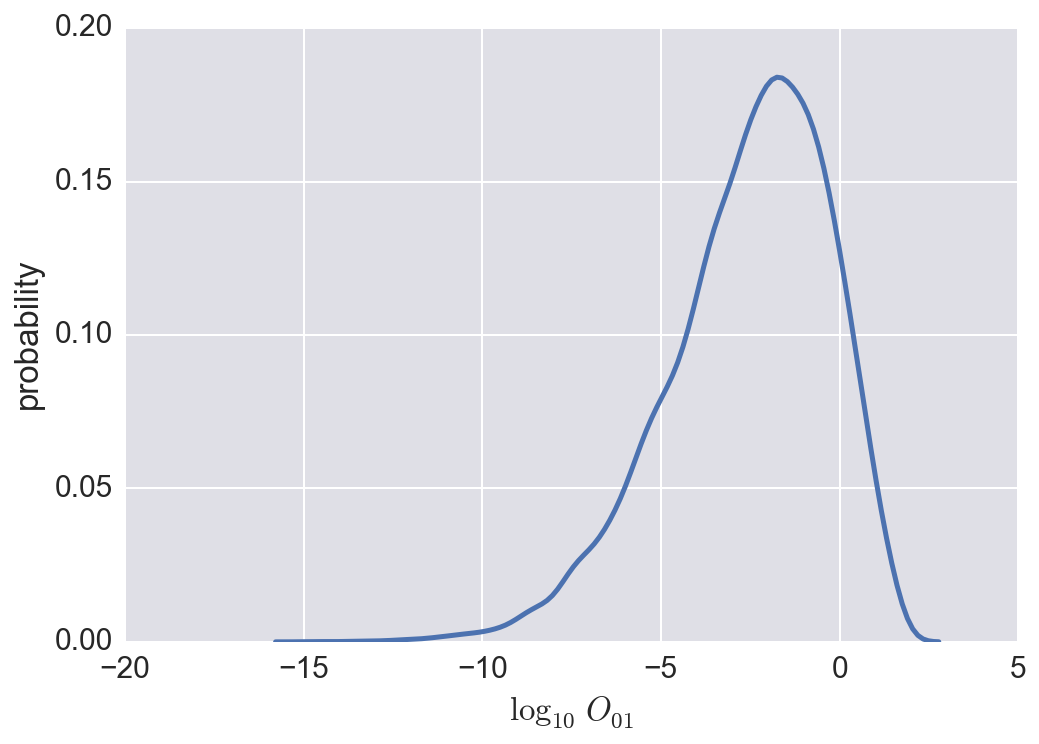

In [166]:
_ = sns.kdeplot(np.log10(odds), kernel='gau', bw='Scott')
plt.xlabel(r'$\log_{10} \,O_{01}$')
plt.ylabel('probability')

With these few samples, it is really difficult to say for sure whether they differ or not because of this reproducibility issue.  What if we upped the sample numbers?

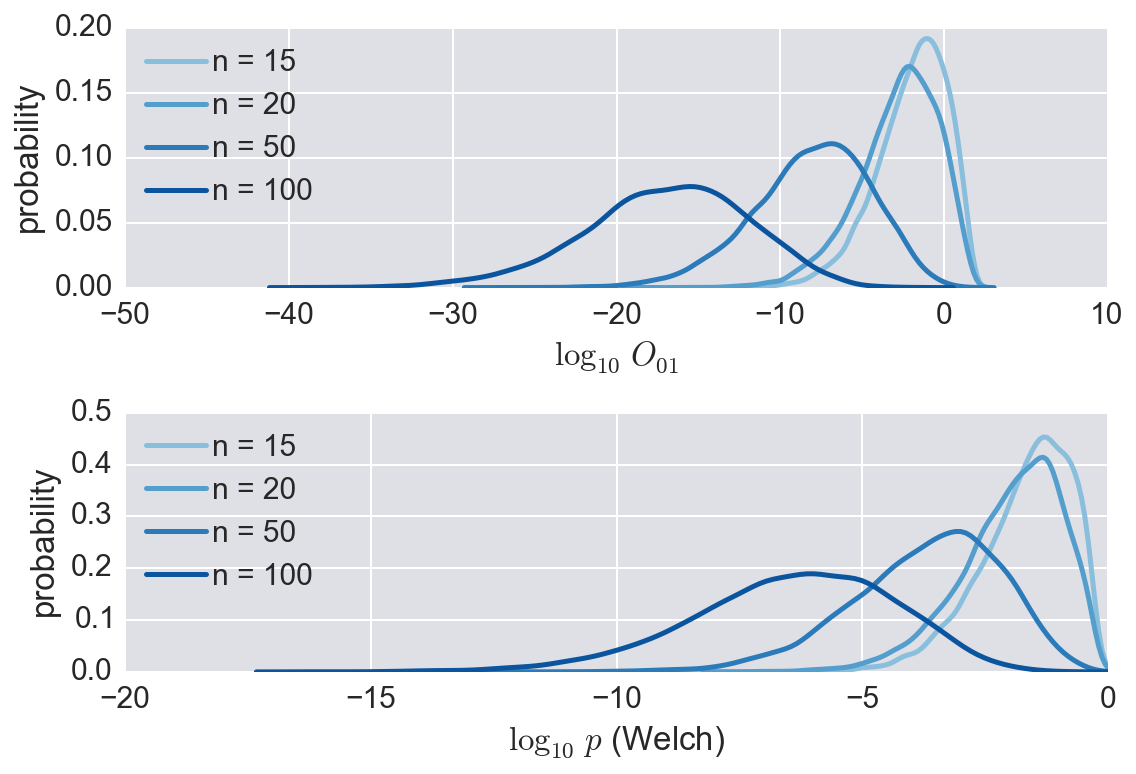

In [173]:
# Number of samples to consider
n_samples = np.array([15, 20, 50, 100])

# Set up figure
fig, ax = plt.subplots(2, 1)

for j, n in enumerate(n_samples):
    # Initialize arrays
    odds = np.empty(n_new_data)
    welch_p_values = np.empty(n_new_data)
    
    # Do calcs!
    for i in range(n_new_data):
        # Generate new data
        new_wt = new_data(mu_wt, var_wt, n)
        new_mut = new_data(mu_mut, var_mut, n)

        # Compute odds ratio
        odds[i] = np.exp(log_odds_ratio(new_wt, new_mut, 0, 60, 1/60, 60)[-1])

        # Compute Welch's p-value
        welch_p_values[i] = st.ttest_ind(new_wt, new_mut, equal_var=False)[1] / 2

    ax[0] = sns.kdeplot(np.log10(odds), kernel='gau', bw='Scott', ax=ax[0], 
                        label='n = {0:d}'.format(n), 
                        color=sns.color_palette('Blues')[j+2])

    ax[1] = sns.kdeplot(np.log10(welch_p_values), kernel='gau', bw='Scott', 
                        ax=ax[1], label='n = {0:d}'.format(n),
                        color=sns.color_palette('Blues')[j+2])
        
ax[0].set_xlabel(r'$\log_{10} \,O_{01}$')
ax[0].set_ylabel('probability')
ax[0].legend(loc='upper left')

ax[1].set_xlabel(r'$\log_{10}\,p$ (Welch)')
ax[1].set_ylabel('probability')
ax[1].set_xlim((-20, 0))
ax[1].legend(loc='upper left')

plt.tight_layout()

We see that even though both the odds ration and the p-value have large spreads as the number of samples increases, they also shift leftward.  This little exercise in reproducibility tells use that because the p-values and odds ratios "dance", we had better be sure the bonfire around which they dance be far to the left.  This suggests large $n$.

I would argue that doing a "dance of the odds ratio" analysis might not be a bad idea to do if you are trying to refute or support hypotheses.  If a "repeat" of your experiment might give you an inconclusive odds ratio, you need to do more experiments.

<br />

### Problem 5.2: Outliers in FRET binding curve

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imaging two proteins, $a$ and $b$ may bind to each other in the reaction

\begin{align}
ab \rightleftharpoons a + b
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of $a$ and $b$ to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed and measure $c_{ab}$ for various $c_b^0$.  We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$.  For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of $a$ is bound to $b$.  Specifically, we take $a$ with a fluorophore and $b$ is a receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molcule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume.  We define by $e$ the FRET efficiency,

\begin{align}
e = 1 - \frac{f}{f_0}.
\end{align}

If we measure $F_0$, the measured fluorescence when there is no b protein in the sample, we can compute the FRET efficiency from  the measured values $F$ and $F_0$

\begin{align}
e =  1 - \frac{c_a^0\,V f}{c_a^0\,Vf_0} = 1 - \frac{F}{F_0}.
\end{align}

Substituting in our expressions for $F$ and $F_0$, we get

\begin{align}
e = 1 - \frac{\left(c_a \,f_0 + c_{ab}\, f_q\right)V}{c_a^0\,V f_0}
= 1 - \frac{c_a}{c_a^0} - \frac{c_{ab}}{c_a^0}\,\frac{f_q}{f_0}.
\end{align}

Using the fact that $c_a^0 = c_a + c_{ab}$, this becomes

\begin{align}
e = \left(1-\frac{f_q}{f_0}\right)\frac{c_{ab}}{c_a^0}.
\end{align}

In other words, the FRET efficiency is proportional to the fraction of a that is bound, or

\begin{align}
e = \alpha \, \frac{c_{ab}}{c_a^0} = \frac{2\alpha\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}},
\end{align}

where $\alpha = 1-f_q/f_0$.  So, we perform a regression with two phenomenological parameters to fit, $\alpha$ and $K_d$.  Note that $0 \le \alpha \le 1$.

**a)** Load in the data for one of these FRET efficiency titration curves.  You can download the data set [here](../data/fret_binding_curve.csv').  Compute the background-subtracted fluorescence and the FRET efficiency.  *These are real data, but they are from an unpublished experiment here on campus.  If you are interested in the proteins we are studying, please ask me and we can discuss.*

**b)** Perform regressions to find $K_d$ with and without an outlier detection scheme.  How do the results differ?

### Problem 5.2: solution

First, we'll load in the data, and look at the `DataFrame`.

In [2]:
df = pd.read_csv('../data/blythe_et_al/fret_binding_curve.csv', comment='#')
df.head()

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50,1500.00
1,1256.5751,267722.6277,50,750.00
2,1256.5751,267431.6620,50,375.00
3,1256.5751,284596.2914,50,187.50
4,1256.5751,254903.3958,50,93.75


To compute the background subtracted fluorescence, we simply subtract the `'buffer'` column from the `'fluorescence'` column.  Then, to compute the FRET efficiency, we divide each background subtracted fluorescence by that with $c_b^0 = 0$.

In [3]:
# Subtract background
df['bg_sub_fluor'] = df['fluorescence'] - df['buffer']

# Compute FRET efficiency (import. use .values in denom b/c of indexing issues)
df['FRET efficiency'] = 1 - df['bg_sub_fluor'] \
                                / df[df['b conc (nM)']==0]['bg_sub_fluor'].values

# Pull out parameters for curve fit
inds = df['b conc (nM)'] > 0
ca0 = df[inds]['a conc (nM)'].values
cb0 = df[inds]['b conc (nM)'].values
e = df[inds]['FRET efficiency'].values

Let's plot the data, FRET efficiency vs. $c_b^0$.

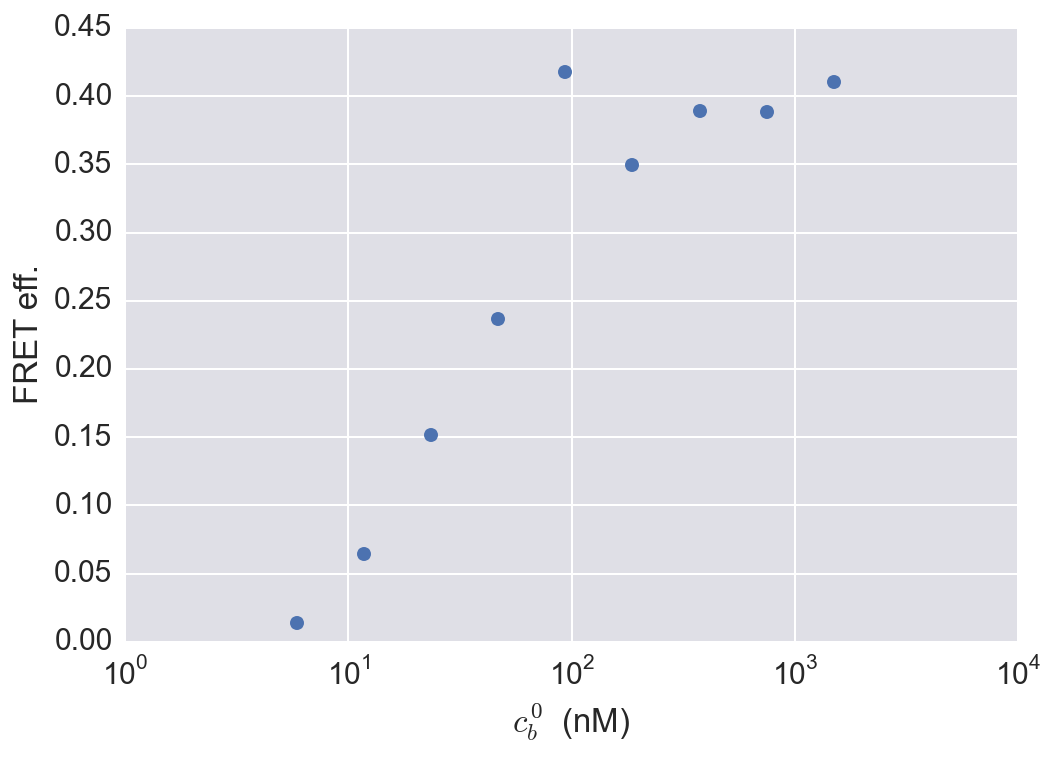

In [4]:
plt.semilogx(cb0, e, 'o')
plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.')

We are sampling the dynamic part of the titration curve, which is good, but we do seem to have a clear outlier.

**b)** Before we can perform the curve fits, we need to write a function for the theoretical FRET efficiency.  First, we'll write a function for the fraction of species a (the donor) that is bound.  We'll then use that to compute the FRET efficiency.  We will use the free energy $\Delta G$ as our parameter to allow for uniform priors and simpler numerics.

In [8]:
@numba.jit(nopython=True)
def fraction_bound(Kd, ca0, cb0):
    """
    Fraction of species a that is bound to b.
    """
    b = Kd + ca0 + cb0
    return 2 * cb0 / (b + np.sqrt(b**2 - 4 * ca0 * cb0))


@numba.jit(nopython=True)
def fret_efficiency(p, ca0, cb0):
    """
    Compute FRET efficiency.  p = [delta_G, alpha, sigma], where
    Kd = exp(-delta_G).
    """
    delta_G, alpha, _ = p
    return alpha * fraction_bound(np.exp(-delta_G), ca0, cb0)

For fitting the data without consideration for outliers, we will use the standard Gaussian likelihood.  To consider outliers, we use a Cauchy likelihood.  Can can code up the log likelihood, prior, and posterior.

In [9]:
def log_prior(p, p_range):
    """
    Log of the prior with p = np.array([delta_G, alpha, sigma]).
    
    p_range = np.array([[delta_G_min, delta_G_max], 
                        [alpha_min,   alpha_max],
                        [sigma_min,   sigma_max]])  
                        
    Substitute beta for sigma if using Cauchy likelihood.
    """
    if (p < p_range[:,0]).any() or (p > p_range[:,1]).any():
        return -np.inf
    
    return -np.log(p_range[:2,1] - p_range[:2,0]).sum() \
                - np.log(np.log(p_range[2,1] / p_range[2,0]) * p[2])

    
@numba.jit(nopython=True)
def log_likelihood(p, cb0, e, ca0, cauchy=False):
    """
    Log likelihood for dissociation measured by FRET efficiency with
    p = np.array([delta_G, alpha, sigma]) or np.array([delta_G, alpha, beta])
    """

    if cauchy:
        return -len(cb0) * np.log(p[2]) \
            - np.sum(np.log(1 + ((e - fret_efficiency(p, ca0, cb0))/ p[2])**2))
    else:
        return -np.sum((e - fret_efficiency(p, ca0, cb0))**2) / 2 / p[2]**2 \
                    - len(cb0) / 2 * np.log(2 * np.pi * p[2]**2)


def log_posterior(p, cb0, e, ca0, p_range, cauchy=False):
    """
    Log posterior for either Gausisan or Cauchy
    """
    lp = log_prior(p, p_range)
    if lp == -np.inf:
        return -np.inf

    return log_likelihood(p, cb0, e, ca0, cauchy=cauchy) + lp


def neg_log_posterior(p, cb0, e, ca0, p_range, cauchy=False):
    return -log_posterior(p, cb0, e, ca0, p_range, cauchy=False)

Because we are only doing a single curve fit and we would like to have information about the posterior, we will use MCMC to do the regression.  First, we'll use a Gaussian likelihood.

In [61]:
# Range of parameter values
p_range = np.array([[-20, 20],
                    [0, 1],
                    [1e-4, 1]])

# Arguments to pass to log posterior
args = (cb0, e, ca0, p_range, False)

# Parameters and how we start them
p_dict = collections.OrderedDict([('delta_G', (np.random.uniform, (-3, 3))),
                                  ('alpha', (np.random.uniform, (0, 1))),
                                  ('sigma', (np.random.uniform, (0.01, 0.5)))])

# Define walker settings
n_walkers = 100
n_burn = 5000
n_steps = 10000

df_mcmc_gauss = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, 
                                           n_walkers=n_walkers, p_dict=p_dict, 
                                           args=args, threads=6)

We can compute $K_d$ from our samples.

In [62]:
df_mcmc_gauss['Kd'] = np.exp(-df_mcmc_gauss['delta_G'])

Now we can make a triangle plot.  We will not put labels on the units in the plot, but note that $\Delta G$ is in some weird units such that when it is exponentiated, the result has units of $K_d$, which are nanomolar.  $\alpha$ and $\sigma$ are dimensionless.

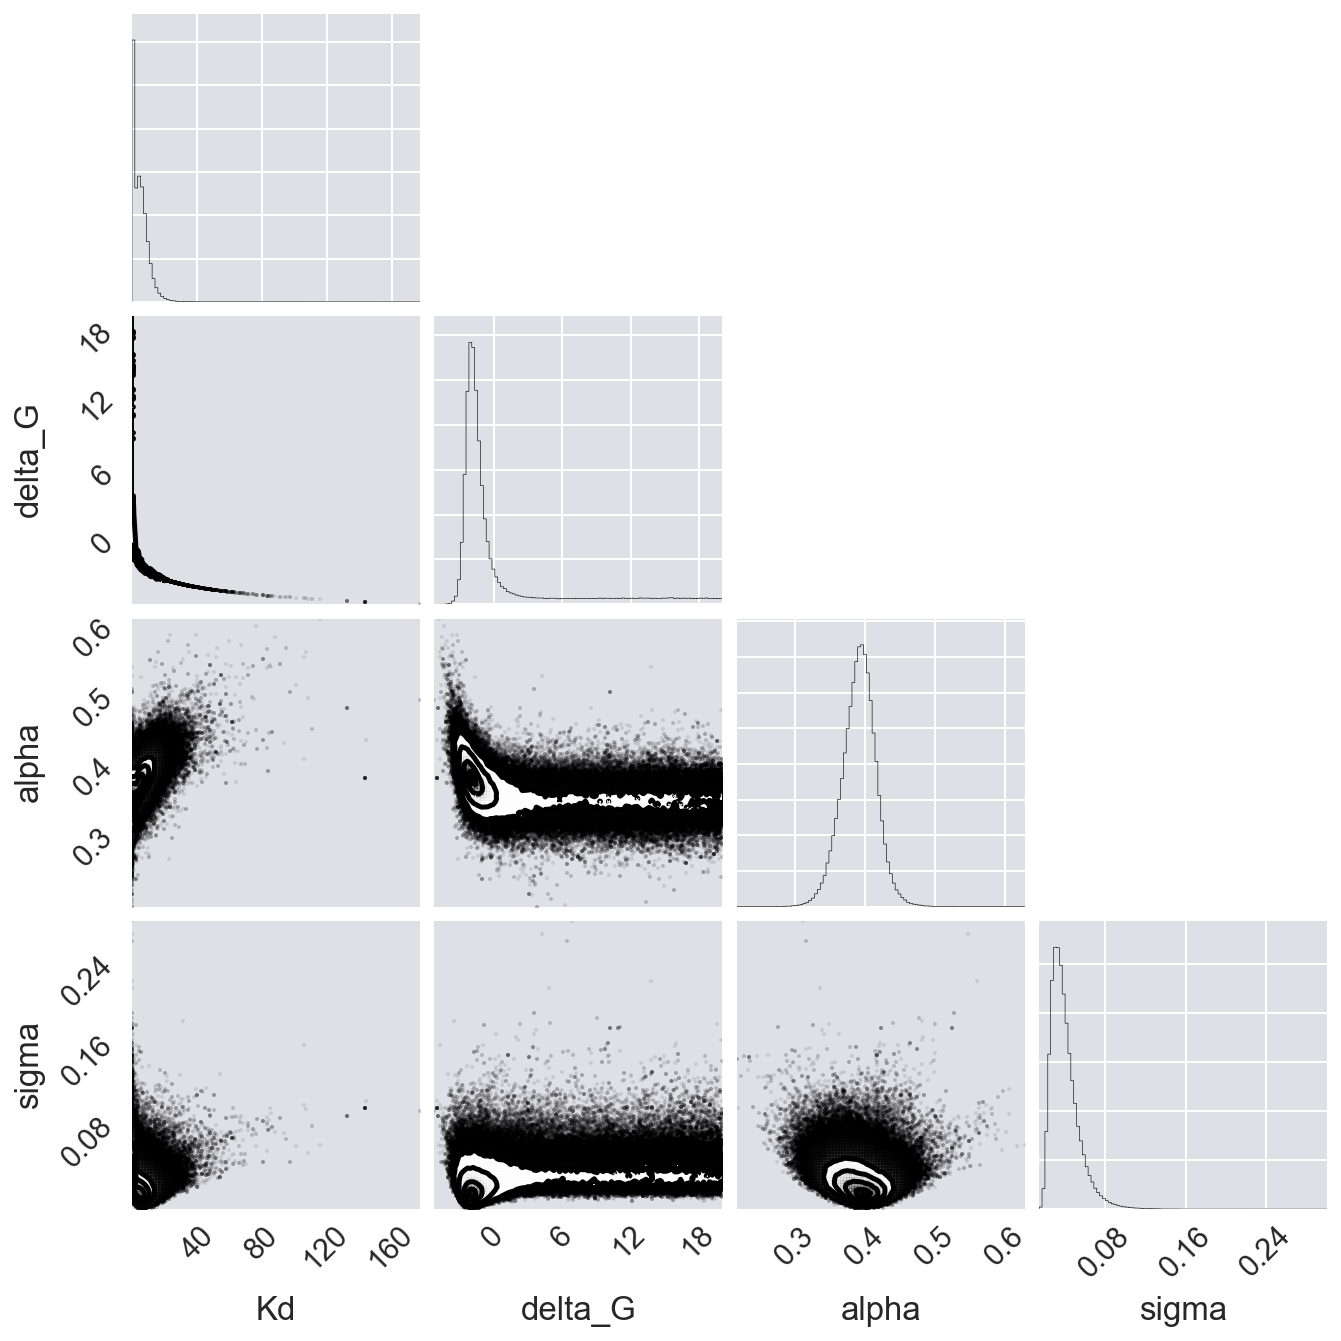

In [63]:
corner.corner(df_mcmc_gauss[['Kd', 'delta_G', 'alpha', 'sigma']], bins=100);

We see that we know pretty well that $\alpha \approx 0.4$.  We see a long tail on $\Delta G$, though, likely due to the presence of the outlier.  Let's now report the results for $K_d$ and $\alpha$ as a mode with HPD containing 68% of the posterior probability.

In [90]:
# Compute HPD for Kd (must be using what was actually sampled)
map_ind = np.argmax(df_mcmc_gauss['lnprob'])
delta_G_mode = df_mcmc_gauss['delta_G'].iloc[map_ind]
delta_G_hpd = bebi103.hpd(df_mcmc_gauss['delta_G'].values, 0.68)
Kd_mode = np.exp(-delta_G_mode)
Kd_hpd = np.exp(-delta_G_hpd)

# Compute HPD for alpha
alpha_mode = df_mcmc_gauss['alpha'].iloc[map_ind]
alpha_hpd = bebi103.hpd(df_mcmc_gauss['alpha'].values, 0.68)

print("""
ΔG = [{1:.2f}   {0:.2f}    {2:.2f}]  in weird units
Kd = [{4:.2e}   {3:.2e}    {5:.2e}]  nM
α =  [{7:.3f}   {6:.3f}    {8:.3f}]
""".format(delta_G_mode, delta_G_hpd[0], delta_G_hpd[1],
           Kd_mode, Kd_hpd[1], Kd_hpd[0], 
           alpha_mode, alpha_hpd[0], alpha_hpd[1]))


ΔG = [-2.81   -1.89    -0.50]  in weird units
Kd = [1.65e+00   6.63e+00    1.65e+01]  nM
α =  [0.370   0.400    0.416]



Because of the long tail in the marginalized posterior for $\Delta G$, we can get exceptionally low $K_d$ values.  This is due to the influence of the outlier, which pulls the best-fit theoretical curve upward.

Let's look at the best fit curve overlayed with the data.

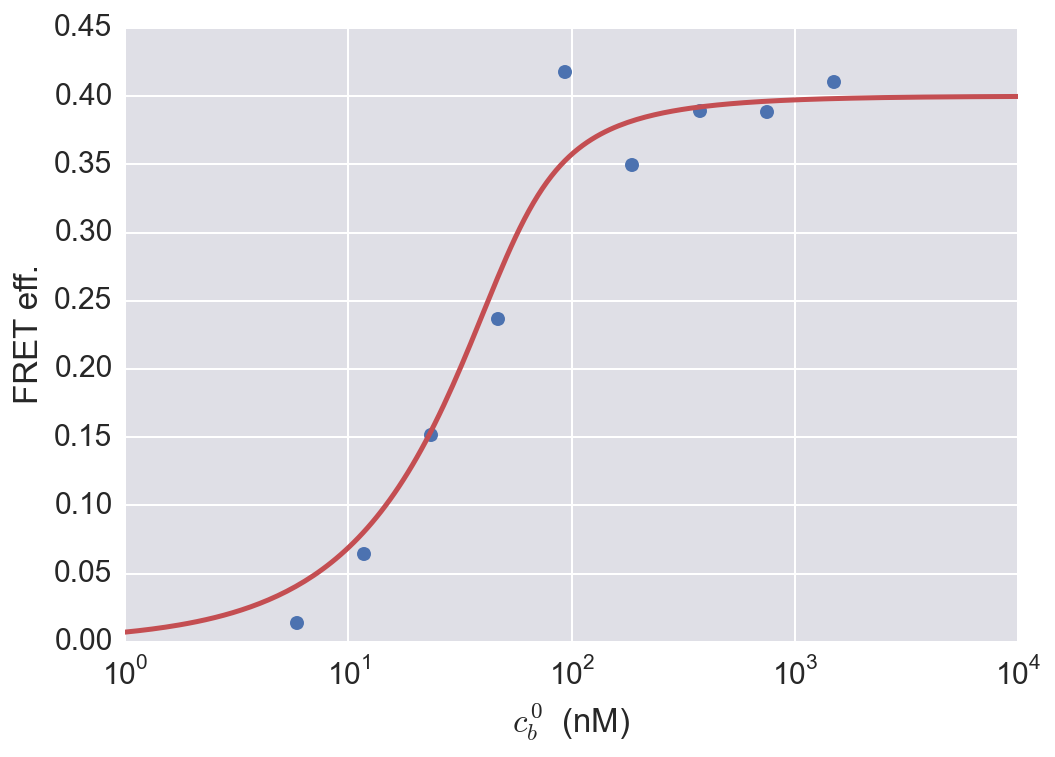

In [65]:
# Generate smooth curve
cb0_smooth = np.logspace(0, 4, 200)
p = np.array([delta_G_mode, alpha_mode, df_mcmc_gauss['sigma'].iloc[map_ind]])
e_smooth = fret_efficiency(p, ca0[0], cb0_smooth)

# Make the plot
plt.semilogx(cb0, e, 'o')
plt.semilogx(cb0_smooth, e_smooth, '-', color=sns.color_palette()[2])
plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.')

Perhaps more informative is a plot where we include the theoretical curves from many of our samples.  We'll pick 1000 random samples and plot those.

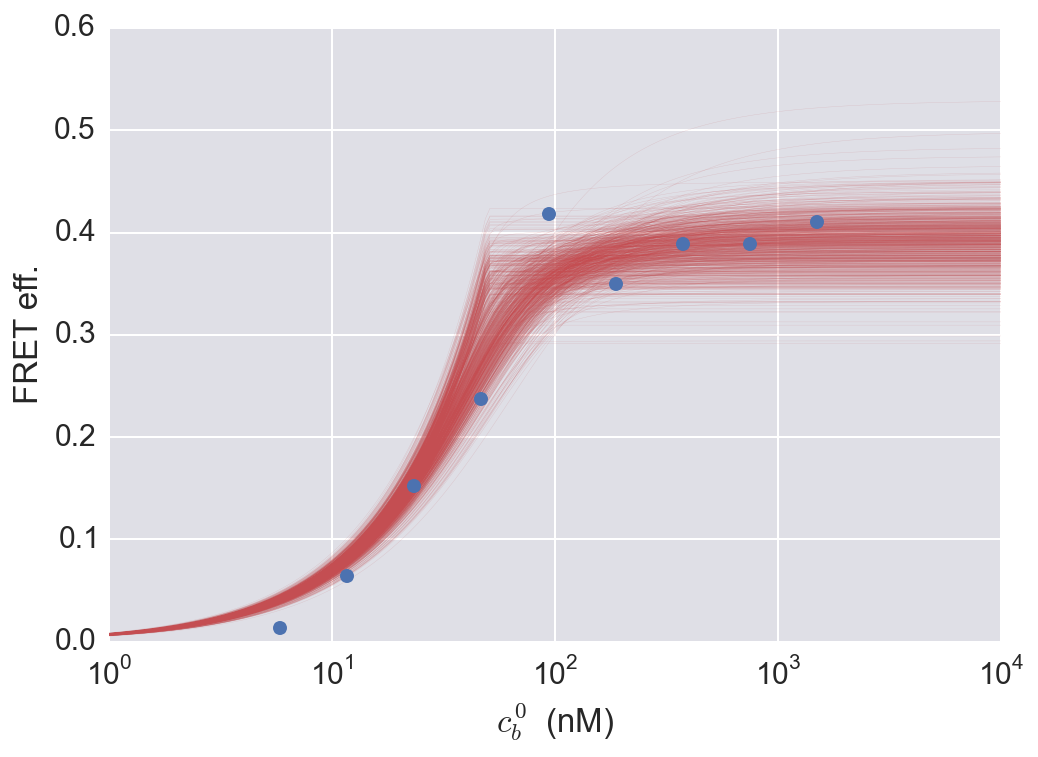

In [66]:
# Which parameter samples to make smooth curves out of
sample_inds = np.random.choice(np.arange(len(df_mcmc_gauss), dtype=int), 1000)

# Smooth x-values
cb0_smooth = np.logspace(0, 4, 200)
# Make the plot
plt.semilogx(cb0, e, 'o', zorder=2)

for ind in sample_inds:
    p = df_mcmc_gauss[['delta_G', 'alpha', 'sigma']].iloc[ind].values
    e_smooth = fret_efficiency(p, ca0[0], cb0_smooth)
    plt.semilogx(cb0_smooth, e_smooth, '-', color=sns.color_palette()[2],
                 lw=0.2, alpha=0.2, zorder=1)

plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.')

Now, let's repeat the analysis using a Cauchy likelihood, which will mitigate the pull of the outlier.  First, we'll run MCMC to get the samples

In [67]:
# Range of parameter values
p_range = np.array([[-20, 20],
                    [0, 1],
                    [1e-4, 1]])

# Arguments to pass to log posterior
args = (cb0, e, ca0, p_range, True)

# Parameters and how we start them
p_dict = collections.OrderedDict([('delta_G', (np.random.uniform, (-3, 3))),
                                  ('alpha', (np.random.uniform, (0, 1))),
                                  ('beta', (np.random.uniform, (0.01, 0.5)))])

# Define walker settings
n_walkers = 100
n_burn = 5000
n_steps = 10000

df_mcmc_cauchy = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, 
                                            n_walkers=n_walkers, p_dict=p_dict, 
                                            args=args, threads=6)

# Compute K_d
df_mcmc_cauchy['Kd'] = np.exp(-df_mcmc_cauchy['delta_G'])

Let's take a look at a nice triangle plot.

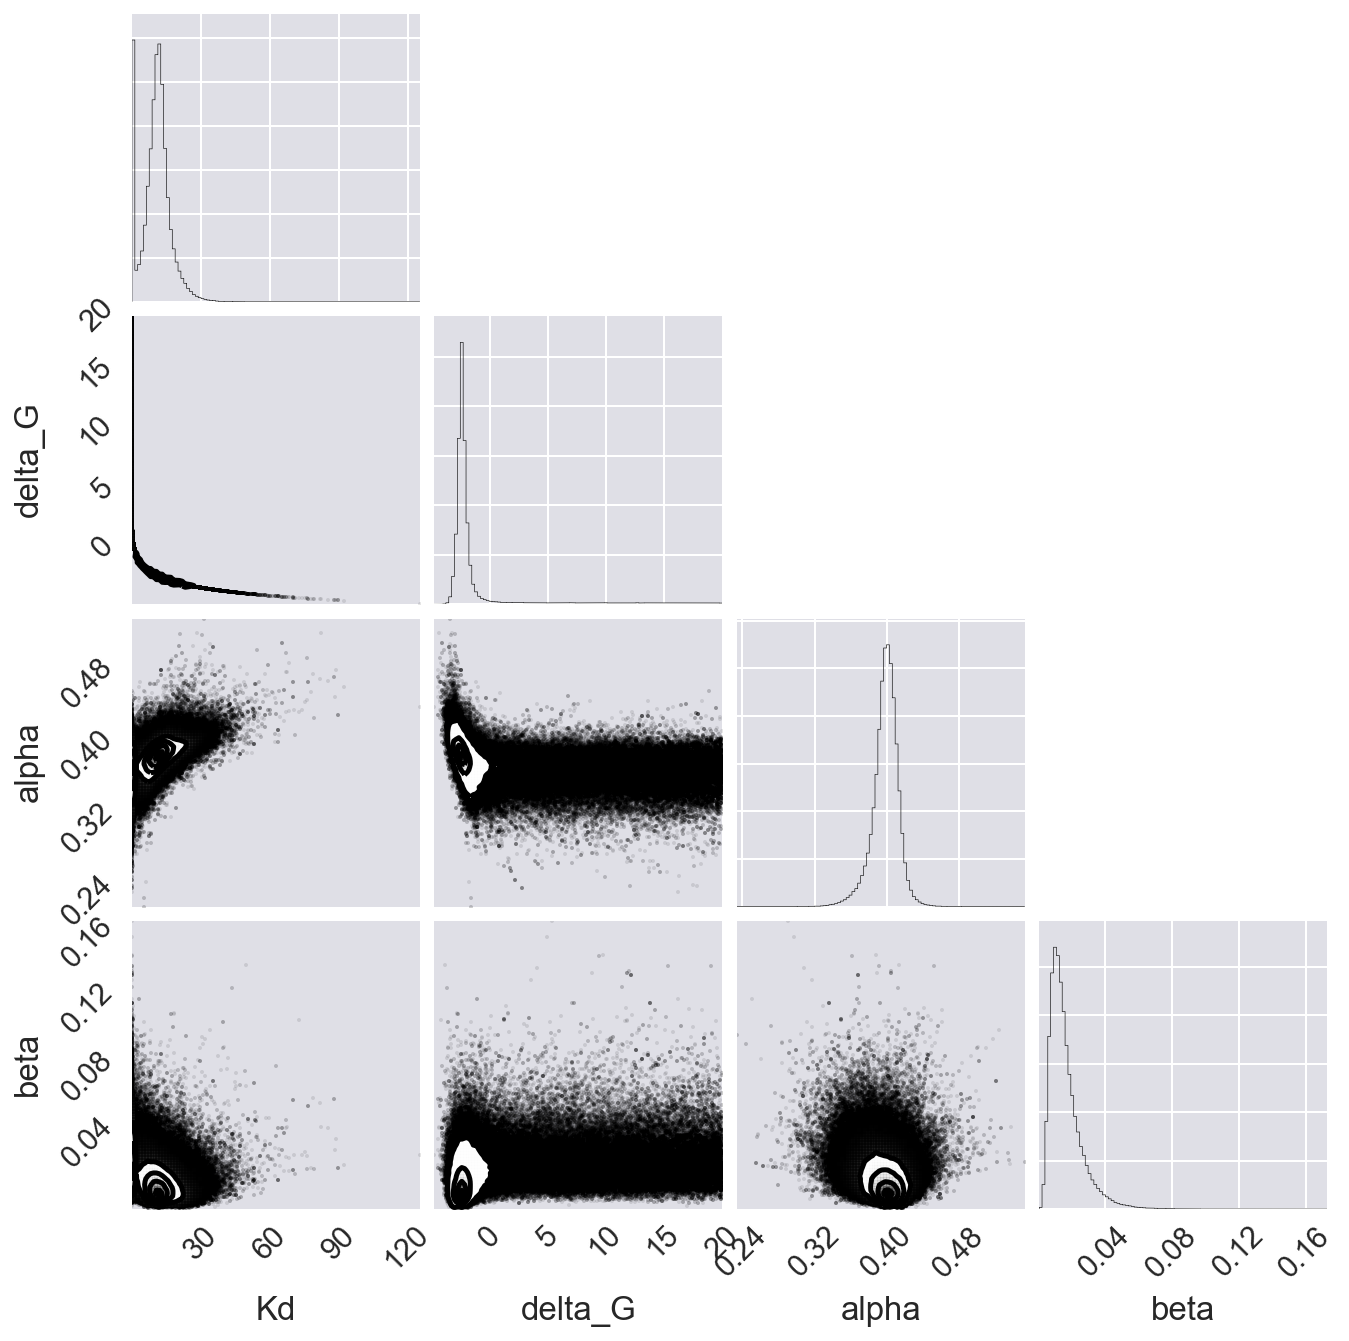

In [68]:
corner.corner(df_mcmc_cauchy[['Kd', 'delta_G', 'alpha', 'beta']], bins=100);

Strikingly, though the outlier still has some influence, the second (relevant) peak in the marginalized $K_d$ distribution is much better-resolved.  The tail on the marginalized $\Delta G$ distribution also falls off much more quickly. 

Now, let's see how this plays our in the credible regions.

In [89]:
# Compute HPD for Kd (must be using what was actually sampled)
map_ind = np.argmax(df_mcmc_cauchy['lnprob'])
delta_G_mode = df_mcmc_cauchy['delta_G'].iloc[map_ind]
delta_G_hpd = bebi103.hpd(df_mcmc_cauchy['delta_G'].values, 0.68)
Kd_mode = np.exp(-delta_G_mode)
Kd_hpd = np.exp(-delta_G_hpd)

# Compute HPD for alpha
alpha_mode = df_mcmc_cauchy['alpha'].iloc[map_ind]
alpha_hpd = bebi103.hpd(df_mcmc_cauchy['alpha'].values, 0.68)


print("""
ΔG = [{1:.2f}   {0:.2f}    {2:.2f}]  in weird units
Kd = [{4:.2e}   {3:.2e}    {5:.2e}]  nM
α = [{7:.3f}   {6:.3f}    {8:.3f}]
""".format(delta_G_mode, delta_G_hpd[0], delta_G_hpd[1],
           Kd_mode, Kd_hpd[1], Kd_hpd[0], 
           alpha_mode, alpha_hpd[0], alpha_hpd[1]))


ΔG = [-2.92   -2.49    -1.95]  in weird units
Kd = [7.05e+00   1.20e+01    1.85e+01]  nM
α = [0.388   0.401    0.412]



The credible region for $K_d$ is still broad, but less so than for the curve fit without outlier detection.  Importantly, we get a most probable $K_d$ that is a factor of two larger than before.  To compare the two, let's compute plot the best-fit curves on the same plot.

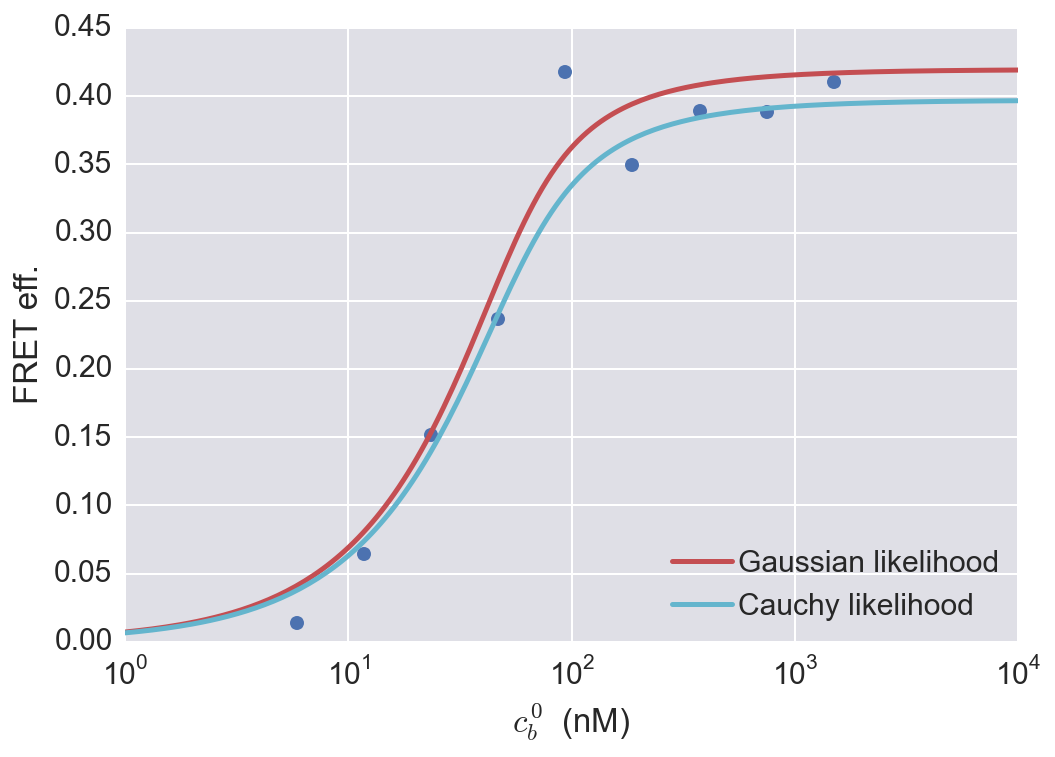

In [79]:
# Generate smooth curves
cb0_smooth = np.logspace(0, 4, 200)
map_ind = np.argmax(df_mcmc_gauss['lnprob'])
p = df_mcmc_gauss[['delta_G', 'alpha', 'sigma']].iloc[ind].values
e_smooth_g = fret_efficiency(p, ca0[0], cb0_smooth)

map_ind = np.argmax(df_mcmc_cauchy['lnprob'])
p = df_mcmc_cauchy[['delta_G', 'alpha', 'beta']].iloc[ind].values
e_smooth_c = fret_efficiency(p, ca0[0], cb0_smooth)


# Make the plot
plt.semilogx(cb0, e, 'o')
plt.semilogx(cb0_smooth, e_smooth_g, '-', color=sns.color_palette()[2],
             label='Gaussian likelihood')
plt.semilogx(cb0_smooth, e_smooth_c, '-', color=sns.color_palette()[5], 
             label='Cauchy likelihood')
plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.')
plt.legend(loc='lower right')

We can see from the plot that the Cauchy likelihood results is far less influence from the outlier.  We can plot a set of curves generated from the Cauchy samples as we did for the Gaussian likelihood.  It is instructive to plot these side-by-side.

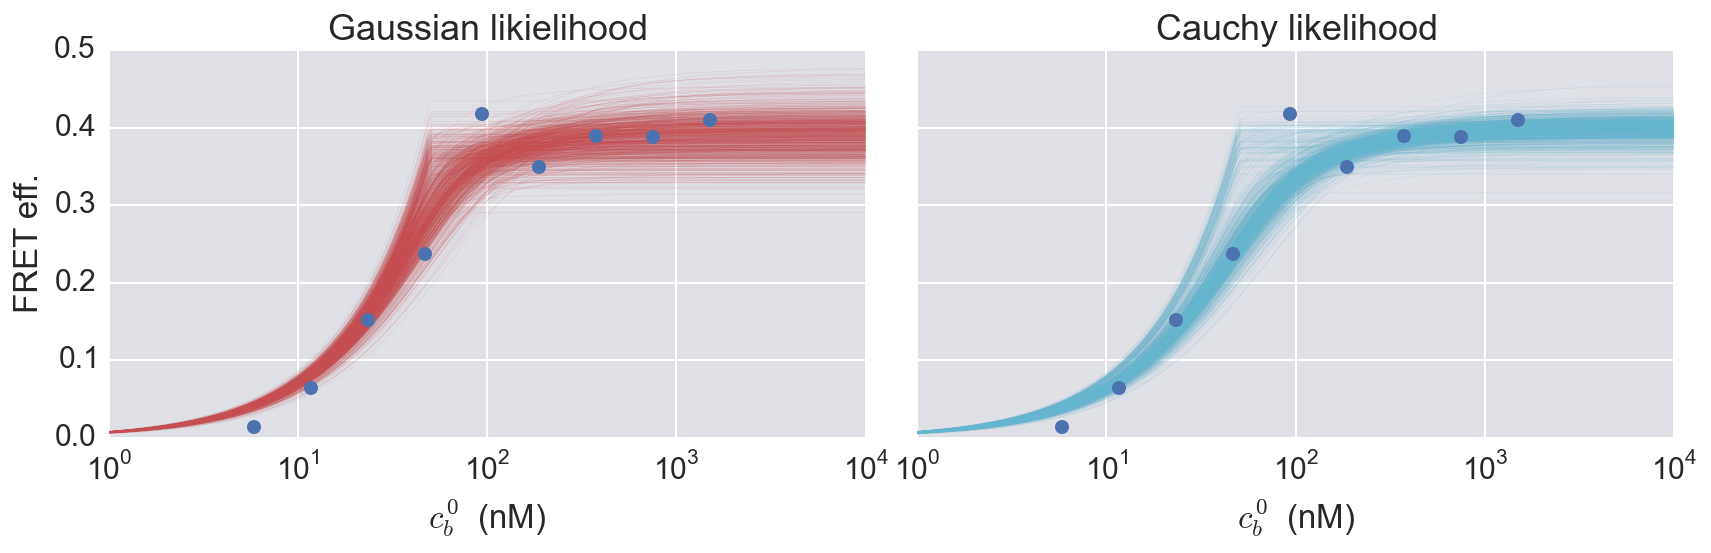

In [86]:
# Make a list of DataFrames and colors
dfs = [df_mcmc_gauss, df_mcmc_cauchy]
c = [sns.color_palette()[2], sns.color_palette()[5]]

# Set up figure
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))

for i, df_ in enumerate(dfs):
    # Which parameter samples to make smooth curves out of
    sample_inds = np.random.choice(np.arange(len(df_), dtype=int), 1000)

    # Smooth x-values
    cb0_smooth = np.logspace(0, 4, 200)
    # Make the plot
    ax[i].semilogx(cb0, e, 'o', zorder=2)

    for ind in sample_inds:
        p = df_[['delta_G', 'alpha', 'lnprob']].iloc[ind].values
        e_smooth = fret_efficiency(p, ca0[0], cb0_smooth)
        ax[i].semilogx(cb0_smooth, e_smooth, '-', color=c[i],
                       lw=0.2, alpha=0.2, zorder=1)

    ax[i].set_xlabel(r'$c_b^0$ (nM)')

ax[0].set_title('Gaussian likielihood')
ax[1].set_title('Cauchy likelihood')
ax[0].set_ylabel('FRET eff.')
plt.tight_layout(w_pad=0.2)

We see that we get some fraction of the curves jump toward the outlier, mostly ignoring the other points at the rightward side of the curve.  We don't see curves that try to walk between the outlier and the remaining data.

So, if we were to report a $K_d$ in a paper, we would be very clear about our parameter estimation method, including explicit mention of the Cauchy likelihood, and report $K_d = 12.0^{+6.5}_{-5.0}$ nM.

Note that this is a nice way to present a confidence interval on $K_d$ because dissociation constants, being exponentiations of free energies, can often have asymmetric distributions.

<br />

### Problem 5.3: Analysis of connections in the human brain (up to 30 pts extra credit)

Use the techniques covered in [Recitation 4](http://bebi103.caltech.edu/2015/protected/tutorials/r4_lasso_ridge.html), or whatever else you would like to try, to try to predict psychological metric from brain connectivity.  You can download the data sets [here](http://bebi103.caltech.edu/2015/protected/data/brain_correlation.zip).

### Problem 5.3: solution
I very much look forward to your analysis, and will share interesting insights with the Adolphs lab.